<a href="https://colab.research.google.com/github/Ananas1Anass/Speech-Recognition/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DON'T FORGET TO RUN ON GPU 
## EDIT --> NOTEBOOK SETTINGS ---> HD accelerator --> GPU

In [ ]:
!git clone https://github.com/Ananas1Anass/Speech-Recognition.git

Cloning into 'Speech-Recognition'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [ ]:
!unzip -u "/content/drive/MyDrive/normalized1.zip" -d "/content/drive/MyDrive/dataset_port"

In [ ]:
!ls /content/drive/MyDrive/dataset_port/normalized1


Ajuda	    Arma	 _background_noise_  Policia  Segurenca
Ambulancia  Assassinato  Faca		     Roubo


In [ ]:
!unzip -u "/content/drive/MyDrive/data_Anass.zip" -d "/content/drive/MyDrive/dataset_eng"

In [ ]:
!ls /content/drive/MyDrive/dataset_eng/

data_Anass  targets_mfcc_32_eng.npz  targets_mfcc_32_port.npz


In [ ]:
!ls /content/drive/MyDrive/dataset_eng/data_Anass/


_background_noise_  bird  down	   go	 off	stop	wow
backward	    cat   follow   left  right	up	yes
bed		    dog   forward  no	 seven	visual	zero


In [ ]:
!ls -l /content/

total 74500
drwx------ 5 root root     4096 Aug 10 01:45 drive
drwxr-xr-x 1 root root     4096 Aug  3 20:21 sample_data
drwxr-xr-x 3 root root     4096 Aug 10 01:35 Speech-Recognition
-rw-r--r-- 1 root root 69206016 Aug 10 01:36 targets_mfcc_32_eng.npz
-rw-r--r-- 1 root root  7045286 Aug 10 01:30 targets_mfcc_32_port.npz
-rw-r--r-- 1 root root    14238 Aug 10 01:50 Training_and_validation_loss.png


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models, metrics
import tensorflow as tf
import numpy as np

In [4]:
# Create list of all targets (minus background noise)
dataset_path = '/content/drive/MyDrive/dataset_eng/data_Anass/'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['bed', 'bird', 'wow', 'seven', 'dog', 'off', 'cat', 'zero', 'forward', 'visual', 'follow', 'down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes', 'backward']


In [5]:
# Settings
feature_sets_path = '/content/drive/MyDrive/dataset_eng/'
feature_sets_filename = 'targets_mfcc_32_eng.npz'
wake_words = all_targets
joined_wake_words = '_'.join(wake_words)
model_filename = f'/content/drive/MyDrive/dataset_eng/wake_words_{joined_wake_words}_work.h5'
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [8]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [9]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
# Peek at labels
print(y_val)

(26417, 32, 32)
(3292, 32, 32)
(3333, 32, 32)
[10. 10. 19. ...  1.  6. 15.]


In [15]:
# Convert ground truth arrays 
wake_words_indexes = [all_targets.index(wake_word) for wake_word in wake_words]
ys_train = np.array(list(map(np.array, zip(*[np.equal(y_train, wake_word_index).astype('float64') for wake_word_index in wake_words_indexes]))))
ys_val = np.array(list(map(np.array, zip(*[np.equal(y_val, wake_word_index).astype('float64') for wake_word_index in wake_words_indexes]))))
ys_test = np.array(list(map(np.array, zip(*[np.equal(y_test, wake_word_index).astype('float64') for wake_word_index in wake_words_indexes]))))
print(ys_train.shape)
print(ys_val.shape)
print(ys_test.shape)

(26417, 20)
(3292, 20)
(3333, 20)


In [ ]:
print(tuple(sum(y_val) / len(y_val) for y_val in zip(*ys_val)))

(0.11755771567436209, 0.027946537059538274, 0.050729040097205344, 0.02703523693803159, 0.05133657351154314, 0.028250303766707167, 0.04495747266099635, 0.05224787363304982, 0.050729040097205344, 0.04374240583232078, 0.10814094775212636, 0.04981773997569866, 0.027946537059538274, 0.022174969623329283, 0.051944106925880924, 0.02399756986634265, 0.024301336573511544, 0.02551640340218712, 0.04981773997569866, 0.12181044957472661)


In [13]:
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0],
                          x_train.shape[1],
                          x_train.shape[2],
                          1)
x_val = x_val.reshape(x_val.shape[0],
                      x_val.shape[1],
                      x_val.shape[2],
                      1)
x_test = x_test.reshape(x_test.shape[0],
                        x_test.shape[1],
                        x_test.shape[2],
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(26417, 32, 32, 1)
(3292, 32, 32, 1)
(3333, 32, 32, 1)
(32, 32, 1)


In [ ]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape,padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape,padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (2, 2),
                        activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(256, (2, 2),
                        activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(1024, (2, 2),
                       activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(1024, (2, 2),
                        activation='relu', padding='same'))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(len(wake_words), activation='sigmoid'))



In [ ]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
# Add training parameters to model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              loss_weights=[1, 100],
              metrics=['acc', metrics.Precision(), metrics.Recall()])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [ ]:
# Train
history = model.fit(x_train,
                    ys_train,
                    epochs=50,
                    batch_size=100,
                    validation_data=(x_val, ys_val),
                    callbacks=[callback],
                   )

Epoch 1/50
265/265 [==============================] - 25s 39ms/step - loss: 0.1972 - acc: 0.1387 - precision: 0.1804 - recall: 0.0108 - val_loss: 0.1587 - val_acc: 0.3144 - val_precision: 0.6607 - val_recall: 0.1337
Epoch 2/50
265/265 [==============================] - 9s 35ms/step - loss: 0.1368 - acc: 0.3990 - precision: 0.7160 - recall: 0.2138 - val_loss: 0.1119 - val_acc: 0.5079 - val_precision: 0.7526 - val_recall: 0.3679
Epoch 3/50
265/265 [==============================] - 9s 36ms/step - loss: 0.0957 - acc: 0.5973 - precision: 0.8077 - recall: 0.4486 - val_loss: 0.0769 - val_acc: 0.6871 - val_precision: 0.8415 - val_recall: 0.5838
Epoch 4/50
265/265 [==============================] - 10s 36ms/step - loss: 0.0705 - acc: 0.7254 - precision: 0.8495 - recall: 0.6316 - val_loss: 0.0636 - val_acc: 0.7591 - val_precision: 0.8430 - val_recall: 0.7029
Epoch 5/50
265/265 [==============================] - 10s 36ms/step - loss: 0.0563 - acc: 0.7829 - precision: 0.8730 - recall: 0.7203 - va

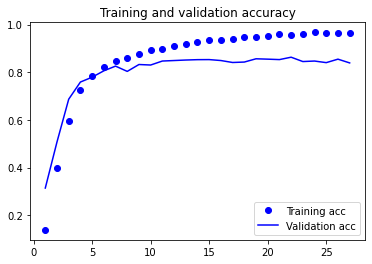

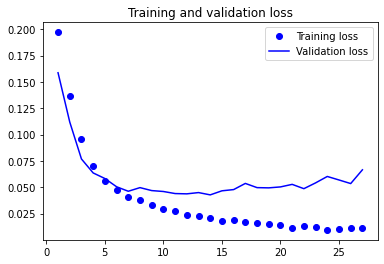

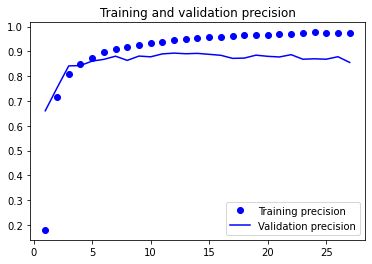

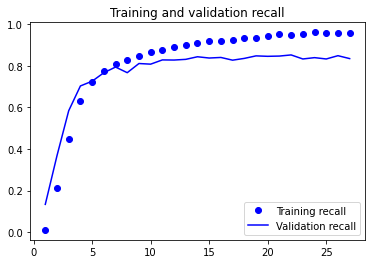

In [ ]:
# Plot results
import matplotlib.pyplot as plt

 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']
precision = history.history['precision']
val_precision = history.history['val_precision']

 


epochs = range(1, len(acc) + 1)

 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

 

plt.figure()

 

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Training_and_validation_loss.png')

 

plt.show()

 


plt.figure()

 

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.savefig('Training_and_validation_precision.png')

 

plt.show()

 

plt.figure()

 

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.savefig('Training_and_validation_recall.png')

 

plt.show()


In [ ]:
# Save the model as a file
models.save_model(model, model_filename)

# See which are stop'
#for idx, y in enumerate(y_test):
#    if y == 1:
#        print(idx)

# TEST: Load model and run it against test set
#model = models.load_model(model_filename)
#for i in range(100, 200):
#    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

# Evaluate model with test set
model.evaluate(x=x_test, y=ys_test)

105/105 [==============================] - 1s 7ms/step - loss: 0.0647 - acc: 0.8557 - precision: 0.8747 - recall: 0.8482


[0.06472723931074142,
 0.8556855916976929,
 0.874690592288971,
 0.8481848239898682]

In [16]:
joined_wake_words = '_'.join(wake_words)
model_filename = f'/content/drive/MyDrive/dataset_eng/wake_words_{joined_wake_words}_work.h5'
model = tf.keras.models.load_model(model_filename)


(26417, 20)


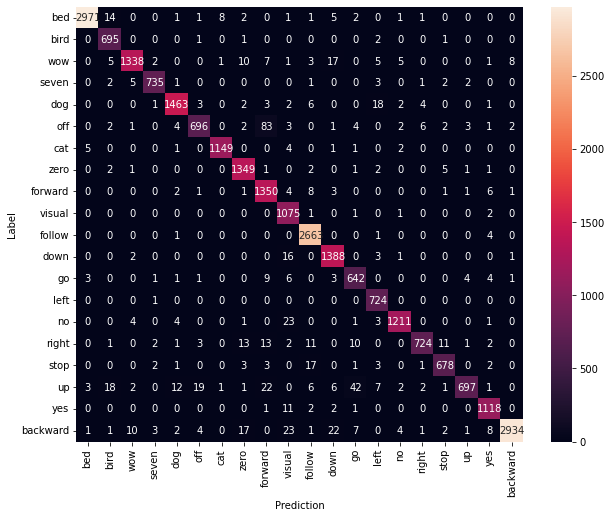

In [19]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred=model.predict(x_train)
print(y_pred.shape)
confusion_mtx = tf.math.confusion_matrix(y_pred.argmax(axis=1),ys_train.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=wake_words,
            yticklabels=wake_words,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [ ]:
all_targets

['bed',
 'bird',
 'wow',
 'seven',
 'dog',
 'off',
 'cat',
 'zero',
 'forward',
 'visual',
 'follow',
 'down',
 'go',
 'left',
 'no',
 'right',
 'stop',
 'up',
 'yes',
 'backward']